In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
import cv2
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader

from data.classification import ImageDataset
from model.classification.vgg16 import VGG16

%load_ext autoreload
%autoreload 2

In [3]:
valid_dir = "../hw2_data/p1_data/val_50"
checkpoint_file = "../run/vgg16_checkpoint/best.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Create dataset
transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]), ])
dataset = ImageDataset(root=valid_dir,
                    transform=transform)

# Create dataloader
dataloader = DataLoader(dataset,
                        batch_size=64,
                        num_workers=4,
                        shuffle=False)

In [5]:
# Load pretrained model
model = VGG16(n_classes=50)

checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['model'])
model = model.to(device)
model = model.eval()
print(model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [6]:
# register hook to get the feature at final convolutional layer
class FeatureVisualizer:
    
    def __init__(self, model):
        self.model = model
        self.features = []
        self.labels = []
        
        # Register feature hook on features module
        feature_layer = self.model.classifier[4]
        self.feature_handler = feature_layer.register_forward_hook(self._feature_hook)

    def _feature_hook(self, module, fin, fout):
        features = fout.detach().cpu().numpy()
        features = features.reshape(features.shape[0], -1)
        self.features.append(features)
    
    def accumulate_feature(self, imgs, labels):
        outputs = self.model(imgs)
        labels = labels.detach().cpu().numpy()
        labels = labels.reshape(labels.shape[0], -1)
        self.labels.append(labels)
        
    def visualize_features(self, n_components=32):
        all_features = np.vstack(self.features)
        all_labels = np.vstack(vis.labels).reshape(-1)
        
        # Perform PCA Dimension reduction
        pca = PCA(n_components=n_components)
        pca.fit(all_features)
        reduced1 = pca.transform(all_features)

        # Perform TSNE Dimension reduction
        tsne = TSNE(n_components=2, n_iter=3000, perplexity=15, verbose=1)
        reduced2 = tsne.fit_transform(reduced1)
        
        # Visualization
        plt.figure(figsize=(16, 8))
        for i, label in enumerate(set(all_labels.tolist())):
            indices = np.where(all_labels == label)[0]
            features = reduced2[indices]
            plt.scatter(features[:, 0], features[:, 1], cmap='hsv')

In [7]:
vis = FeatureVisualizer(model)

# Accumulate features
for imgs, labels in dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    vis.accumulate_feature(imgs, labels)

vis.feature_handler.remove()

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.004s...
[t-SNE] Computed neighbors for 2500 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 4.517444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.317177
[t-SNE] KL divergence after 3000 iterations: 0.704147


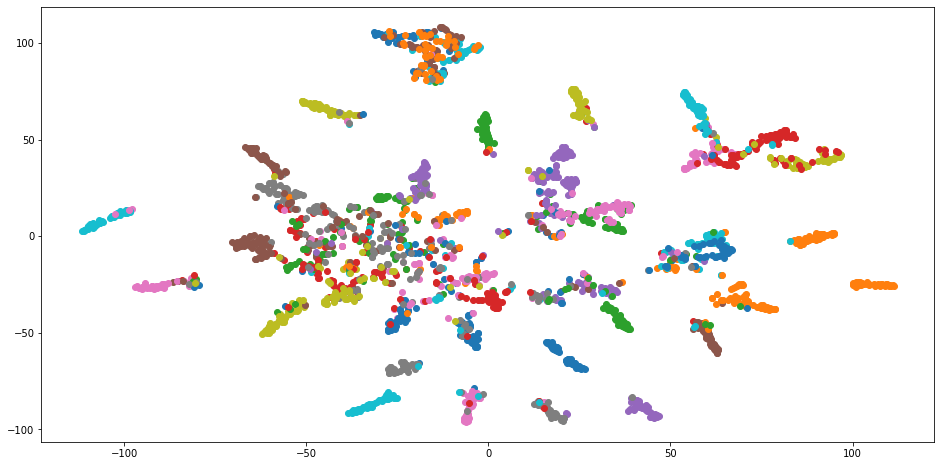

In [8]:
vis.visualize_features()